### Unlocking Positivity: Sentiment Analysis of 'Hot Sensitive Topics' in the MakeupAddiction Subreddit for Enhanced User Engagement and Brand Strategies


 * Business Goals
 
   The objective is to gauge the sentiment and community reception of content within the top 30 tags with the most comments on the "MakeupAddiction" subreddit, identified as "Hot sensitive topics." Understanding the sentiment distribution, especially the proportion of positive attitudes, will empower creators, moderators, and brands to Adjust their content creation to align with positively received topics, enhancing user engagement and satisfaction. Brands can position their products and messages in a way that resonates positively with the subreddit's community. Moderators can identify potential areas of contention or exceptionally positive topics, aiding in community management and policy development. Gain insights into current trends and consumer mood, informing marketing strategies and product development.

* Technical Proposal
  
    To achieve the outlined business goals, we propose the following technical approach:Pull submissions data from the "MakeupAddiction" subreddit, focusing on posts tagged with the top 30 tags with the most comments, which constitute "Hot sensitive topics." Then Utilize Natural Language Processing (NLP) tools to perform sentiment analysis on the `title` and `body` of submissions. This will involve preprocessing text data to remove noise and normalize text, employing sentiment analysis algorithms, like VADER or TextBlob, which are particularly adept at handling social media text and classifying sentiment into categories such as positive and negative.Calculate the proportion of posts that exhibit a positive sentiment within each hot topic tag, providing a sentiment distribution profile. By systematically implementing this sentiment analysis, stakeholders can align their strategies with the positive dynamics of the community, potentially leading to increased engagement, improved brand perception, and more effective community management.


### Step 1: Set Up PySpark Session and Read Data from S3

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [4]:
spark = SparkSession.builder \
    .appName("Spark NLP and PySparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "16G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", 
            "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider") \
    .getOrCreate()


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-81688880-4cee-45b8-862b-7fc5a2afda46;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")
sampled_submissions = submissions.sample(withReplacement=False, fraction=0.1, seed=123)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-834346005548/project/submissions/yyyy=*


23/11/18 23:41:45 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/18 23:41:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68
CPU times: user 3.38 s, sys: 251 ms, total: 3.63 s
Wall time: 6min 4s



### Step 2: Data Preprocessing

In [6]:
import sparknlp
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, desc, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import plotly.express as px
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline

In [7]:
# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("link_flair_text") \
    .setOutputCol("document")

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Normalizer
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# Finisher
finisher = Finisher() \
    .setInputCols(["normalized"])

# Pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher
])

# Apply the pipeline
processed_tags_df = nlp_pipeline.fit(sampled_submissions).transform(sampled_submissions)


In [8]:
# Group by normalized tag and sum the number of comments
tag_comments_df = processed_tags_df.groupBy("finished_normalized").agg(sum_("num_comments").alias("total_comments"))

In [9]:
from pyspark.sql.functions import col, explode, regexp_replace, expr, sum as sum_

In [11]:
windowSpec = Window.orderBy(desc("total_comments"))
ranked_tags_df = tag_comments_df.withColumn("rank", rank().over(windowSpec))

In [12]:
cleaned_tags_df = ranked_tags_df.withColumn("tag", explode(col("finished_normalized"))) \
                                .withColumn("tag", regexp_replace(col("tag"), r"[\[\]]", "")) \
                                .withColumn("tag", expr("CASE WHEN tag = 'fotd' THEN 'face of the day' ELSE tag END"))


In [13]:
tag_comments_df = cleaned_tags_df.groupBy("tag").agg(sum_("total_comments").alias("total_comments"))

In [14]:
# Rank tags based on total comments
windowSpec = Window.orderBy(desc("total_comments"))
ranked_tags_df = tag_comments_df.withColumn("rank", rank().over(windowSpec))

In [15]:
# Filter to top 30 tags
top_30_tags_df = ranked_tags_df.filter(col("rank") <= 30).drop("rank")

In [16]:
top_100_tags_df = ranked_tags_df.filter(col("rank") <= 100).drop("rank")
top_tags_pandas_df100 = top_100_tags_df.toPandas()

23/11/18 23:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:57:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:57:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:57:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 2

In [17]:
import pandas as pd
import plotly.express as px

# Convert to a Pandas DataFrame
top_tags_pandas_df = top_30_tags_df.toPandas()

23/11/18 23:57:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:57:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/18 23:57:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:02:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:02:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:02:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 0

In [52]:
fig.write_html('top_30_tags.html')


In [22]:
import plotly.graph_objects as go
top_tags_pandas_df100['Rank'] = range(1, len(top_tags_pandas_df100) + 1)

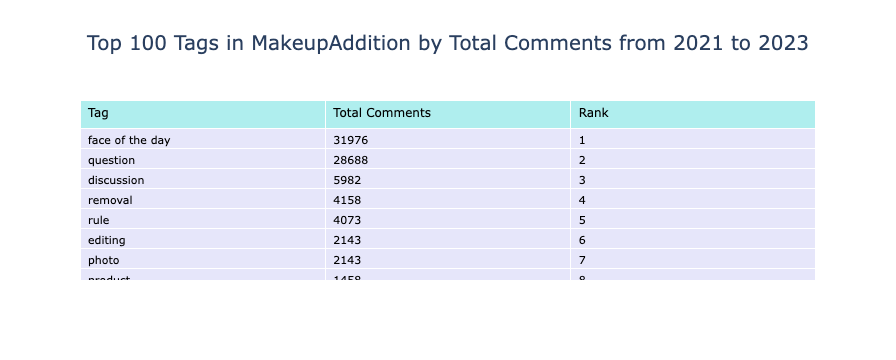

In [26]:
# Create a Plotly Table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=['Tag', 'Total Comments','Rank'],
        fill_color='paleturquoise',  # Header background color
        align='left',
        font=dict(color='black', size=12)  # Header font color and size
    ),
    cells=dict(
        values=[top_tags_pandas_df100[k].tolist() for k in top_tags_pandas_df100.columns],
        fill_color='lavender',  # Cell background color
        align='left',
        font=dict(color='black', size=11)  # Cell font color and size
    ))
])

# Add a title to the figure
fig.update_layout(
    title_text='Top 100 Tags in MakeupAddition by Total Comments from 2021 to 2023',  # Title of the table
    title_x=0.5,  # Center the title
    title_font=dict(size=20)  # Title font size
)


# Show the figure
fig.show()

In [72]:
fig.write_html('top_100_tag_table.html')

The initial strategy to analyze the top 100 tags was recalibrated to the top 30 after data preprocessing revealed a pivotal insight: the subreddit's dialogue was clustered around a narrower spectrum of topics. The data revealed a pronounced concentration of discussions within these top tags, as illustrated by the table where the frequency of comments noticeably declines beyond the 30th tag. This concentration indicates that the community's discourse is not spread thinly over numerous subjects but is instead deeply rooted in a select few areas of significant interest. By focusing our NLP and sentiment analysis on these core 30 tags, we ensure that our evaluation is not only more robust due to the rich density of data points within each category but also more representative of the subreddit's active and dynamic discussions. This pivot to a more targeted analysis of the top 30 tags allows us to deliver insights with greater precision, offering a distilled view of the community's pulse and enabling stakeholders to craft strategies that resonate strongly with the most engaging content areas.

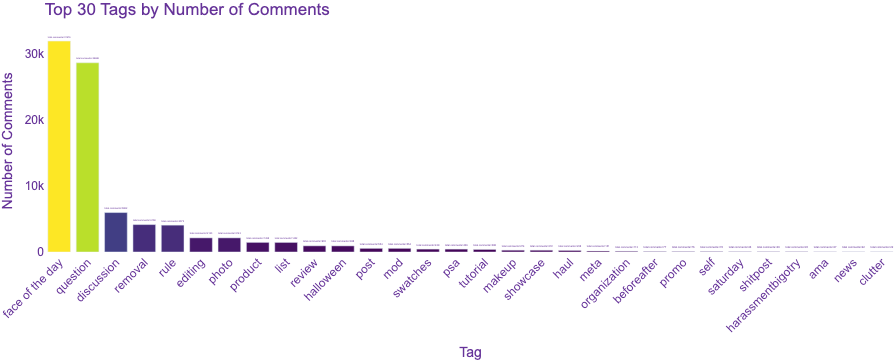

In [27]:
import plotly.express as px

# Assuming 'top_tags_pandas_df' is your DataFrame and it's already been prepared.
# If you don't have it prepared, you need to first convert your Spark DataFrame to a Pandas DataFrame.

fig = px.bar(
    top_tags_pandas_df,
    x='tag',
    y='total_comments',
    title='Top 30 Tags by Number of Comments',
    text='total_comments',  # Display the count on the bars
    color='total_comments',  # Add a color scale based on the number of comments
    color_continuous_scale=px.colors.sequential.Viridis  # Aesthetic color scale
)

# Customize the layout and style
fig.update_layout(
    xaxis_title="Tag",
    yaxis_title="Number of Comments",
    xaxis_tickangle=-45,  # Angle the x-axis labels for better readability
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
    font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),  # Customize font
    margin=dict(l=0, r=0, t=30, b=0),  # Adjust margins to fit the layout
)

# Customize bar labels
fig.update_traces(
    text=top_tags_pandas_df['total_comments'].apply(lambda x: f'total comments={x}'),
    textposition='outside'  # Position the text above the bars
)

# Remove the color bar if not desired
fig.update(layout_coloraxis_showscale=False)

# Show the figure
fig.show()


The graph titled "Top 30 Tags by Number of Comments" visualizes the distribution of comments across various tags in the "MakeupAddiction" subreddit. It's immediately apparent that the community engagement is heavily skewed towards a few specific tags, with "face of the day" and "question" garnering the most attention, indicated by the tallest bars on the graph. These two tags alone have a significantly higher number of comments—over 30,000 and nearly 29,000 respectively—highlighting them as the most popular and engaging topics within the community.

As we move beyond these tags, there's a steep drop-off in the number of comments, with the third most popular tag, "discussion," having just under 6,000 comments. The graph then shows a gradual decline as we move through the subsequent tags. This pattern indicates that while there is a range of topics that interest the community, a select few topics dominate the conversation. The sharp decrease from the second to the third tag and the relatively flat distribution amongst the remaining tags suggest that while the subreddit has a variety of discussions, user engagement is concentrated in top-tier topics. 

The lower end of the graph, which includes tags such as "self," "saturday," "shitpost," "harassmentbigotry," "ama," and "news," has the least number of comments, all below 100. This suggests that these topics are either more niche or less provocative of discussion among the community members.

Overall, the graph effectively illustrates the disparity in user engagement across different discussion tags within the "MakeupAddiction" subreddit and could be indicative of the community's preferences or the influence of trending topics at the time of data collection. For stakeholders looking to engage with or market to this community, focusing on the highly engaging tags could provide better visibility and interaction rates.

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, explode, regexp_replace, expr, sum as sum_, desc, when
from pyspark.sql.window import Window
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType, FloatType
def sentiment_analysis(text):
    from textblob import TextBlob
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis, FloatType())

In [29]:
# Register the UDF with Spark
sentiment_analysis_udf = udf(sentiment_analysis, StringType())

# Add sentiment score to the processed DataFrame for title and body (selftext)
processed_tags_df = processed_tags_df.withColumn("sentiment_score_title", sentiment_analysis_udf(col("title")))
processed_tags_df = processed_tags_df.withColumn("sentiment_score_body", sentiment_analysis_udf(col("selftext")))

# Define the UDF to convert sentiment scores into categories
def sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Register the UDF with Spark
sentiment_category_udf = udf(sentiment_category, StringType())

# Add sentiment category columns for title and body
processed_tags_df = processed_tags_df.withColumn("sentiment_category_title", sentiment_category_udf(col("sentiment_score_title")))
processed_tags_df = processed_tags_df.withColumn("sentiment_category_body", sentiment_category_udf(col("sentiment_score_body")))

# Explode the 'finished_normalized' column to create a single tag per row
cleaned_tags_df = processed_tags_df.withColumn("tag", explode(col("finished_normalized")))

# Clean up the tag format to match the top tags DataFrame
cleaned_tags_df = cleaned_tags_df.withColumn("tag", regexp_replace(col("tag"), r"[\[\]]", ""))
cleaned_tags_df = cleaned_tags_df.withColumn("tag", expr("CASE WHEN tag = 'fotd' THEN 'face of the day' ELSE tag END"))

# Assuming 'top_30_tags_df' contains the top 30 tags
# Filter submissions for top 30 tags
top_30_submissions_with_sentiment = cleaned_tags_df.join(top_30_tags_df, ["tag"])

In [32]:
# First, count the number of each sentiment category within each tag
sentiment_counts = top_30_submissions_with_sentiment.groupBy("tag", "sentiment_category_title").count()

# Then, calculate the total sentiments for each tag
total_sentiments = sentiment_counts.groupBy("tag").agg(sum_("count").alias("total"))

# Join the counts with the totals to calculate proportions
sentiment_proportions = sentiment_counts.join(total_sentiments, "tag")

# Now calculate the proportion for each sentiment category
sentiment_proportions = sentiment_proportions.withColumn("proportion", col("count") / col("total"))

# Select the columns of interest and possibly other transformations/formatting
sentiment_proportions = sentiment_proportions.select(
    col("tag"), 
    col("sentiment_category_title"), 
    col("proportion")
)

# Show the final proportions DataFrame
sentiment_proportions.show()

23/11/19 00:17:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:17:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:17:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:17:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 00:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 0

+---------------+------------------------+-------------------+
|            tag|sentiment_category_title|         proportion|
+---------------+------------------------+-------------------+
|            psa|                Negative|0.16981132075471697|
|            psa|                Positive|0.37735849056603776|
|            psa|                 Neutral| 0.4528301886792453|
|            ama|                Positive| 0.3333333333333333|
|            ama|                 Neutral| 0.6666666666666666|
|        editing|                Negative|0.10679611650485436|
|        editing|                Positive| 0.4077669902912621|
|        editing|                 Neutral| 0.4854368932038835|
|          promo|                Negative|0.05555555555555555|
|          promo|                 Neutral| 0.4444444444444444|
|          promo|                Positive|                0.5|
|face of the day|                 Neutral| 0.4000940291490362|
|face of the day|                Positive| 0.4522802068

In [ ]:
sentiment_proportion_pd = sentiment_proportions.toPandas()

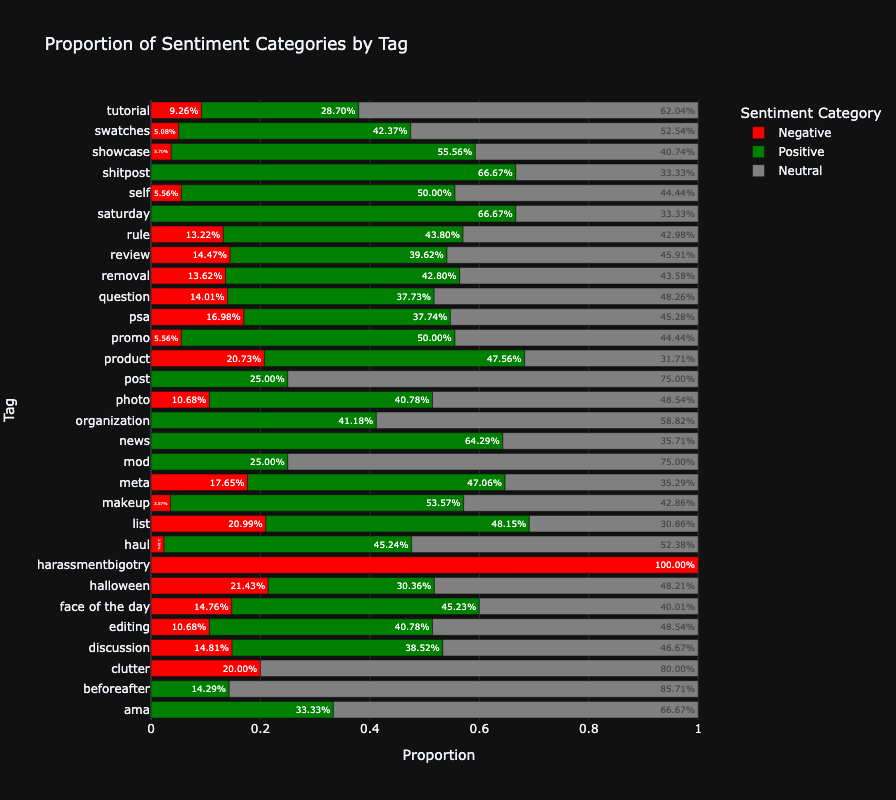

In [34]:
# We need to pivot the data to have separate columns for each sentiment category
sentiment_proportion_pd = sentiment_proportion_pd.pivot(index='tag', columns='sentiment_category_title', values='proportion').reset_index()

# Create the plot
fig = px.bar(
    sentiment_proportion_pd,
    x=['Negative', 'Positive', 'Neutral'],
    y='tag',
    title='Proportion of Sentiment Categories by Tag',
    orientation='h',
    color_discrete_map={
        'Negative': 'red',
        'Positive': 'green',
        'Neutral': 'grey'
    },
    height=800,
    width=1600
)

# Improve layout and style
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Proportion',
    yaxis_title='Tag',
    yaxis={'categoryorder': 'total ascending'},
    legend_title_text='Sentiment Category',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Customize bar labels
fig.update_traces(
    texttemplate='%{value:.2%}',
    textposition='inside'
)

The provided bar chart visualizes the proportion of sentiment categories—Positive, Neutral, and Negative—across various tags. The data suggests a predominant occurrence of Neutral sentiments across most tags, which implies a balanced or moderate tone in discussions related to those topics. Notably, the tags associated with 'tutorial', 'swatches', and 'showcase' exhibit a higher percentage of Positive sentiments, indicating a favorable reception or approval from the community in these areas.

Conversely, the 'harassmentbigotry' tag shows an overwhelming Negative sentiment, which could be attributed to discussions around negative experiences or issues that are critically viewed by the community. The 'face of the day' and 'haul' tags also display a significant portion of Positive sentiment, suggesting these are well-received topics within the community.

The presence of Positive sentiment in creative or personal sharing tags like 'tutorial', 'swatches', and 'haul' could reflect a supportive community environment that encourages individual expression. In contrast, the high Negative sentiment in 'harassmentbigotry' could reflect community concerns or discussions around sensitive topics.

Overall, the chart provides a valuable snapshot of the community's emotional response to different topics, highlighting areas of common interest, support, and contention. This insight could guide content moderation, community engagement strategies, and the development of resources to foster positive interactions and address areas of concern.

In [52]:
fig.write_html('top30-senti-prop.html')

In [53]:
# First, count the number of each sentiment category within each tag
sentiment_counts = top_30_submissions_with_sentiment.groupBy("tag", "sentiment_category_body").count()

# Then, calculate the total sentiments for each tag
total_sentiments = sentiment_counts.groupBy("tag").agg(sum_("count").alias("total"))

# Join the counts with the totals to calculate proportions
sentiment_proportions = sentiment_counts.join(total_sentiments, "tag")

# Now calculate the proportion for each sentiment category
sentiment_proportions = sentiment_proportions.withColumn("proportion", col("count") / col("total"))

# Select the columns of interest and possibly other transformations/formatting
sentiment_proportions = sentiment_proportions.select(
    col("tag"), 
    col("sentiment_category_body"), 
    col("proportion")
)

# Show the final proportions DataFrame
sentiment_proportions.show()

23/11/19 01:02:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:02:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:02:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:02:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:08:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:08:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 0

+---------------+-----------------------+--------------------+
|            tag|sentiment_category_body|          proportion|
+---------------+-----------------------+--------------------+
|            psa|               Negative|0.018867924528301886|
|            psa|                Neutral|  0.8301886792452831|
|            psa|               Positive|  0.1509433962264151|
|            ama|                Neutral|                 1.0|
|        editing|                Neutral|                 1.0|
|          promo|                Neutral|                 1.0|
|face of the day|               Negative|0.005641748942172073|
|face of the day|                Neutral|  0.9732016925246827|
|face of the day|               Positive|0.021156558533145273|
|           news|                Neutral|                 1.0|
|           meta|               Positive| 0.17647058823529413|
|           meta|                Neutral|  0.8235294117647058|
|        removal|               Positive|0.007782101167

In [57]:
sentiment_proportion_pd = sentiment_proportions.toPandas()

23/11/19 01:21:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:21:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:21:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:21:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:27:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 01:27:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/19 0

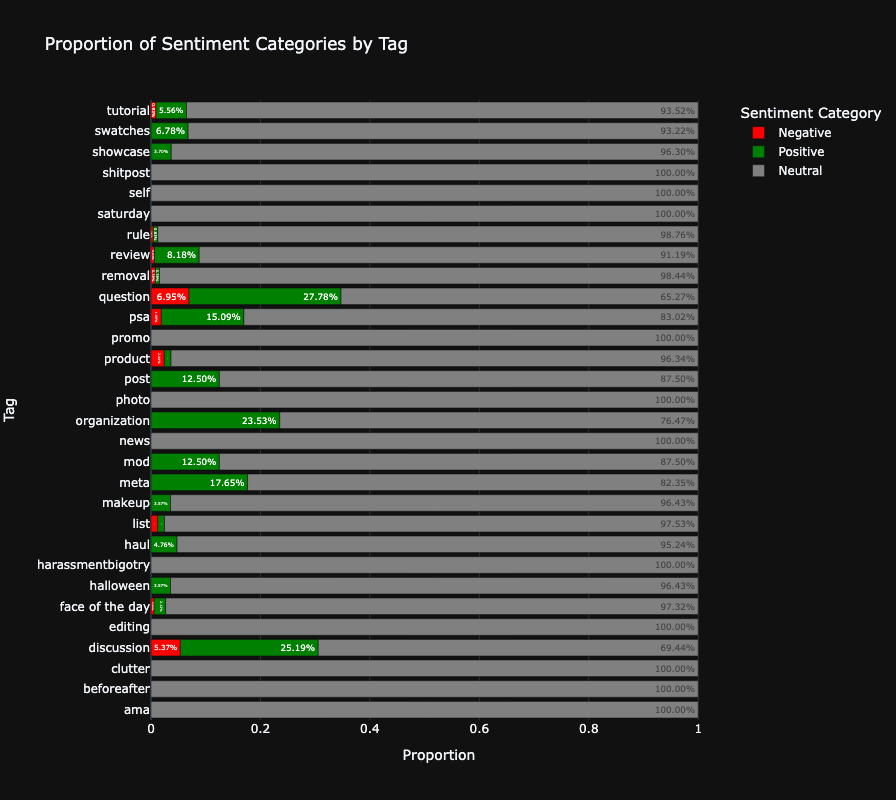

In [58]:
# We need to pivot the data to have separate columns for each sentiment category
sentiment_proportion_pd = sentiment_proportion_pd.pivot(index='tag', columns='sentiment_category_body', values='proportion').reset_index()

# Create the plot
fig = px.bar(
    sentiment_proportion_pd,
    x=['Negative', 'Positive', 'Neutral'],
    y='tag',
    title='Proportion of Sentiment Categories of Body of Submission by Tag',
    orientation='h',
    color_discrete_map={
        'Negative': 'red',
        'Positive': 'green',
        'Neutral': 'grey'
    },
    height=800,
    width=1600
)

# Improve layout and style
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Proportion',
    yaxis_title='Tag',
    yaxis={'categoryorder': 'total ascending'},
    legend_title_text='Sentiment Category',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Customize bar labels
fig.update_traces(
    texttemplate='%{value:.2%}',
    textposition='inside'
)

The bar chart presents the proportion of sentiment categories—Negative, Neutral, and Positive—associated with different tags derived from the "MakeupAddiction" subreddit. At a glance, the predominance of green bars, which signify positive sentiment, suggests that the overall tone of discussions is generally positive across the majority of tags. This indicates an engaging and supportive community atmosphere, especially in discussions around "tutorial," "swatches," and "haul," where the Positive sentiment seems to be notably high.

Some tags, like "review" and "question," have a significant presence of red bars, indicating a higher proportion of negative sentiments. These could potentially point to critical evaluations or challenging questions within the community discourse. The "psa" (public service announcement) tag shows a relatively balanced distribution across all three sentiment categories, which could signify a mix of informative, advisory, and cautionary tones in these posts.

The "harassmentbigotry" tag stands out with a high negative sentiment, likely reflecting serious discussions around negative experiences or issues within the community that evoke a strong emotional response.

The visualization serves as a helpful tool for subreddit moderators and community managers to understand the emotional undertones across different discussion topics, which can inform content moderation policies and community engagement strategies. It also provides an indication of which topics are received well by the community and which may require more attention due to the presence of negative sentiments.

In [59]:
fig.write_html('top30-senti-prop-body.html')